In [1]:
import scvelo as scv
import numpy as np
import pandas as pd

import scanpy as sc
import matplotlib.pyplot as plt 

from velocity_scripts import local_velocity_smoothness,extract_knn_from_adata,umap_velocity_via_joint,trajectory_series

# Setup

In [2]:
adata = scv.datasets.pancreas()


In [3]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)


In [4]:
hvg = np.loadtxt("./ZPSGenes.tsv",dtype=str)
hvg.shape

(1352,)

In [5]:
filtered = adata[:,hvg]

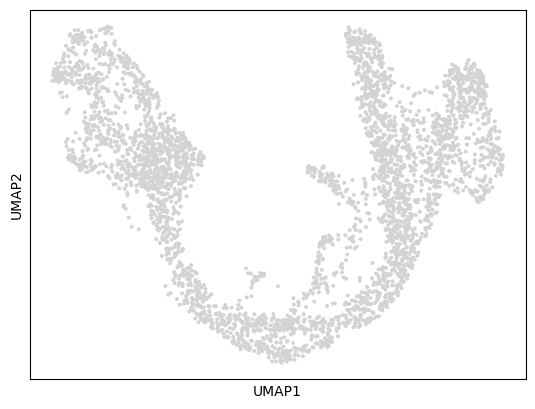

In [6]:
sc.pp.neighbors(filtered)
sc.tl.umap(filtered)
sc.pl.umap(filtered)

In [7]:
scv.pp.moments(filtered,n_neighbors=None,n_pcs=None)

scv.tl.velocity(filtered)
scv.tl.velocity_graph(filtered)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/bbrener1/miniconda3/envs/fo

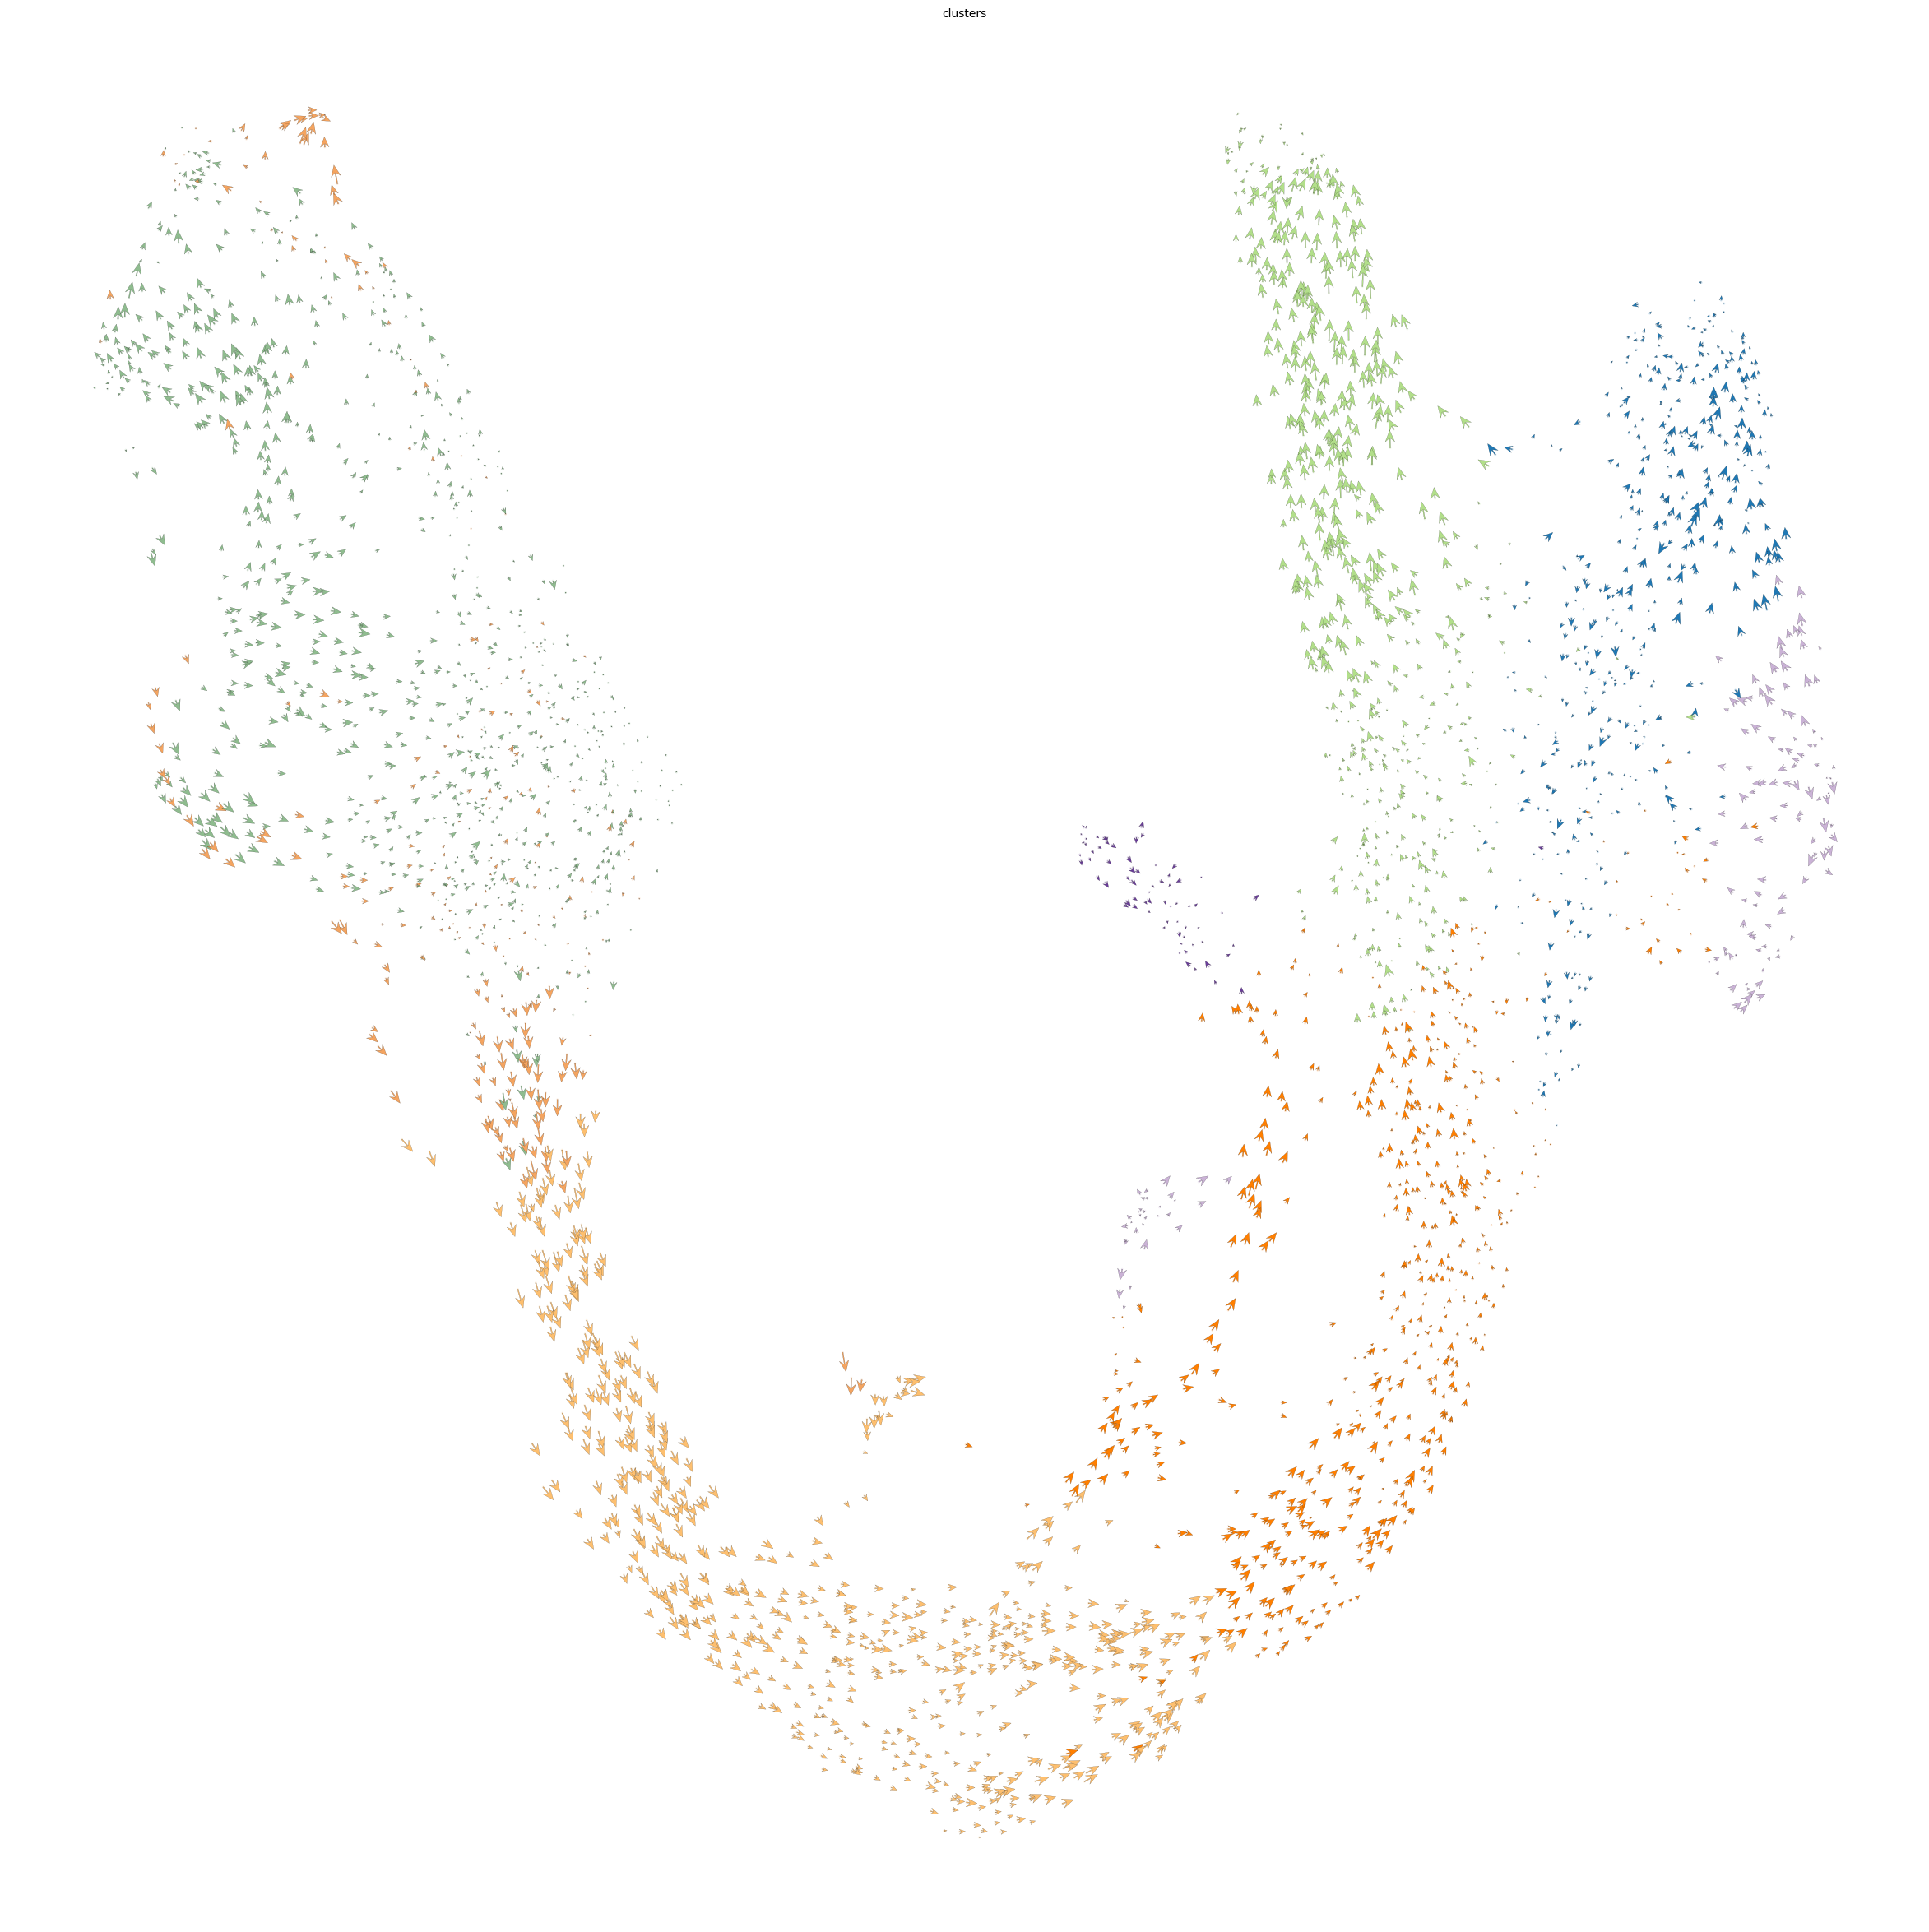

In [8]:
scv.pl.velocity_embedding(filtered,figsize=(30,30))

In [9]:
scv_raw_v = filtered.layers['velocity']

In [10]:
knn = extract_knn_from_adata(filtered)

In [11]:
scv.tl.velocity_embedding(filtered,basis="umap")
scv_umap_v = filtered.obsm['velocity_umap']

scv_umap_t0 = filtered.obsm["X_umap"]
scv_umap_t1 = scv_umap_t0 + scv_umap_v

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


# Embedding 

In [12]:
sc.pp.pca(filtered,n_comps=50)

scv.tl.velocity_embedding(filtered,basis="pca")
scv_pca_v = filtered.obsm['velocity_pca']

scv_pca_t0 = filtered.obsm["X_pca"]
scv_pca_t1 = scv_pca_t0 + (scv_pca_v)

pca_velocity_norm = np.linalg.norm(scv_pca_v,axis=1)
filtered.obs['pca_velocity_norm'] = pca_velocity_norm

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


# Training

In [13]:
import sys

sys.path.append("/Users/bbrener1/haxx/RNAForecasterPaperCode/src/")
import python_interface as py_n

In [ ]:
for i in range(10):

    training_params = {
        "hiddenLayerNodes": 50,
        "batchSize": 200,
        "learningRate":1e-4,
        "nEpochs":1000,
        "ensembleSuffix":i,
        "seed":i
    }
    
    # prediction_params = {
    #     "tSteps":20,
    #     "damping":.7,
    #     "ensembleSuffix":i,
    # }
    
    py_n.train(scv_pca_t0,scv_pca_t1,params=training_params)
    
    # pca_futures = py_n.predict(scv_pca_t0,params=prediction_params)
    
    # pca_futures.shape

In [14]:
pca_futures = np.zeros((5,*scv_pca_t0.shape))
pca_one_step = np.zeros((5,*scv_pca_t0.shape))

for i in range(5):

    training_params = {
        "hiddenLayerNodes": 50,
        "batchSize": 200,
        "learningRate":1e-4,
        "nEpochs":1000,
        "ensembleSuffix":i
    }
    
    prediction_params = {
        "tSteps":6,
        "damping":1,
        "ensembleSuffix":i,
    }
    
    pred = py_n.predict(scv_pca_t0,params=prediction_params)

    pca_futures[i] = pred[-1]
    pca_one_step[i] = pred[0]


The latest version of Julia in the `release` channel is 1.10.4+0.aarch64.apple.darwin14. You currently have `1.10.3+0.aarch64.apple.darwin14` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.4+0.aarch64.apple.darwin14 and update the `release` channel to that version.
  Activating project at `~/haxx/RNAForecasterPaperCode`


Working at /Users/bbrener1/haxx/RNAForecasterPaperCode/src/tmp
Read params Dict{Symbol, Real}(:tSteps => 6, :useGPU => false, :batchSize => 100, :ensembleSuffix => 0, :damping => 1.0f0), Dict{Symbol, Real}(:nEpochs => 1000, :useGPU => false, :hiddenLayerNodes => 50, :batchSize => 200, :learningRate => 0.0001, :ensembleSuffix => 5, :seed => 5)
Predicting step 1
Predicting step 2
Predicting step 3
Predicting step 4
Predicting step 5
Predicting step 6
Writing timepoint 1
Writing timepoint 2
Writing timepoint 3
Writing timepoint 4
Writing timepoint 5
Writing timepoint 6


The latest version of Julia in the `release` channel is 1.10.4+0.aarch64.apple.darwin14. You currently have `1.10.3+0.aarch64.apple.darwin14` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.4+0.aarch64.apple.darwin14 and update the `release` channel to that version.
  Activating project at `~/haxx/RNAForecasterPaperCode`


Working at /Users/bbrener1/haxx/RNAForecasterPaperCode/src/tmp
Read params Dict{Symbol, Real}(:tSteps => 6, :useGPU => false, :batchSize => 100, :ensembleSuffix => 1, :damping => 1.0f0), Dict{Symbol, Real}(:nEpochs => 1000, :useGPU => false, :hiddenLayerNodes => 50, :batchSize => 200, :learningRate => 0.0001, :ensembleSuffix => 5, :seed => 5)
Predicting step 1
Predicting step 2
Predicting step 3
Predicting step 4
Predicting step 5
Predicting step 6
Writing timepoint 1
Writing timepoint 2
Writing timepoint 3
Writing timepoint 4
Writing timepoint 5
Writing timepoint 6


The latest version of Julia in the `release` channel is 1.10.4+0.aarch64.apple.darwin14. You currently have `1.10.3+0.aarch64.apple.darwin14` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.4+0.aarch64.apple.darwin14 and update the `release` channel to that version.
  Activating project at `~/haxx/RNAForecasterPaperCode`


Working at /Users/bbrener1/haxx/RNAForecasterPaperCode/src/tmp
Read params Dict{Symbol, Real}(:tSteps => 6, :useGPU => false, :batchSize => 100, :ensembleSuffix => 2, :damping => 1.0f0), Dict{Symbol, Real}(:nEpochs => 1000, :useGPU => false, :hiddenLayerNodes => 50, :batchSize => 200, :learningRate => 0.0001, :ensembleSuffix => 5, :seed => 5)
Predicting step 1
Predicting step 2
Predicting step 3
Predicting step 4
Predicting step 5
Predicting step 6
Writing timepoint 1
Writing timepoint 2
Writing timepoint 3
Writing timepoint 4
Writing timepoint 5
Writing timepoint 6


The latest version of Julia in the `release` channel is 1.10.4+0.aarch64.apple.darwin14. You currently have `1.10.3+0.aarch64.apple.darwin14` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.4+0.aarch64.apple.darwin14 and update the `release` channel to that version.
  Activating project at `~/haxx/RNAForecasterPaperCode`


Working at /Users/bbrener1/haxx/RNAForecasterPaperCode/src/tmp
Read params Dict{Symbol, Real}(:tSteps => 6, :useGPU => false, :batchSize => 100, :ensembleSuffix => 3, :damping => 1.0f0), Dict{Symbol, Real}(:nEpochs => 1000, :useGPU => false, :hiddenLayerNodes => 50, :batchSize => 200, :learningRate => 0.0001, :ensembleSuffix => 5, :seed => 5)
Predicting step 1
Predicting step 2
Predicting step 3
Predicting step 4
Predicting step 5
Predicting step 6
Writing timepoint 1
Writing timepoint 2
Writing timepoint 3
Writing timepoint 4
Writing timepoint 5
Writing timepoint 6


The latest version of Julia in the `release` channel is 1.10.4+0.aarch64.apple.darwin14. You currently have `1.10.3+0.aarch64.apple.darwin14` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.4+0.aarch64.apple.darwin14 and update the `release` channel to that version.
  Activating project at `~/haxx/RNAForecasterPaperCode`


Working at /Users/bbrener1/haxx/RNAForecasterPaperCode/src/tmp
Read params Dict{Symbol, Real}(:tSteps => 6, :useGPU => false, :batchSize => 100, :ensembleSuffix => 4, :damping => 1.0f0), Dict{Symbol, Real}(:nEpochs => 1000, :useGPU => false, :hiddenLayerNodes => 50, :batchSize => 200, :learningRate => 0.0001, :ensembleSuffix => 5, :seed => 5)
Predicting step 1
Predicting step 2
Predicting step 3
Predicting step 4
Predicting step 5
Predicting step 6
Writing timepoint 1
Writing timepoint 2
Writing timepoint 3
Writing timepoint 4
Writing timepoint 5
Writing timepoint 6


In [15]:
mean_future = np.mean(pca_futures,axis=0)
mean_step = np.mean(pca_one_step,axis=0)

In [ ]:
for future in pca_futures:
    pca_umap_t0,pca_umap_t1,pca_umap_v = umap_velocity_via_joint(scv_pca_t0,future)
    trajectory_series([pca_umap_t0,pca_umap_t1],frequency=3)

In [ ]:
pca_futures[0]

In [ ]:
pca_futures[1]

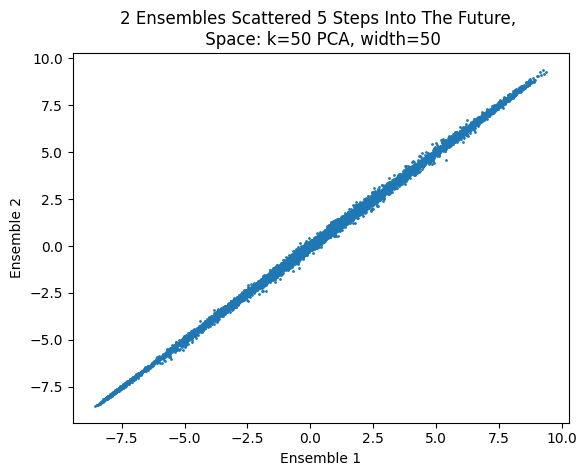

In [30]:
plt.figure()
plt.title("2 Ensembles Scattered 5 Steps Into The Future, \n Space: k=50 PCA, width=50")
plt.scatter(pca_futures[0].flatten(),pca_futures[1].flatten(),s=1)
plt.xlabel("Ensemble 1")
plt.ylabel("Ensemble 2")
plt.show()

In [ ]:
plt.figure()
plt.scatter(pca_futures[1].flatten(),pca_futures[2].flatten(),s=1)
plt.show()

In [ ]:
plt.figure()
plt.scatter(pca_one_step[3].flatten(),pca_one_step[4].flatten(),s=1)
plt.show()

In [ ]:
plt.figure()
plt.scatter(scv_pca_t0.flatten(),pca_futures[4].flatten(),s=1)
plt.show()

In [ ]:
pca_futures[0]

In [ ]:
pca_futures

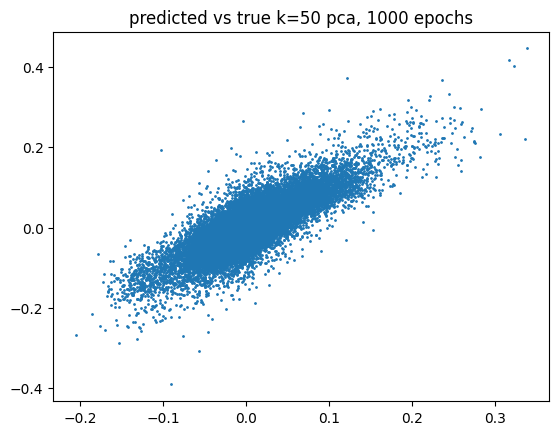

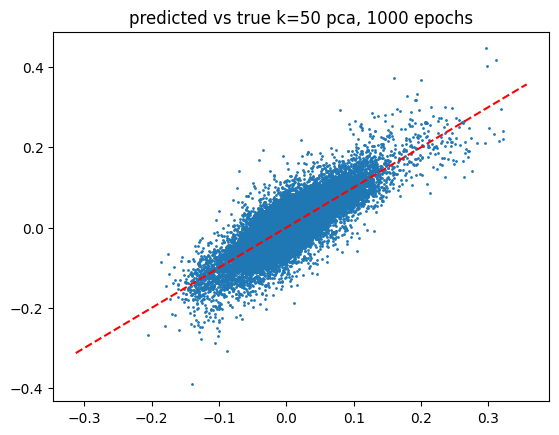

In [21]:
pca_predicted_delta_0 = pca_one_step[0] - scv_pca_t0
pca_predicted_delta_1 = pca_one_step[1] - scv_pca_t0

plt.figure()
plt.title("predicted vs true k=50 pca, 1000 epochs")
plt.scatter(pca_predicted_delta_0.flatten(),scv_pca_v.flatten(),s=1)
# axlim_min = min(min(pca_predicted_delta.flatten()),min(scv_pca_v.flatten())) * .8
# axlim_max = max(max(pca_predicted_delta.flatten()),max(scv_pca_v.flatten())) * .8
# plt.plot([axlim_min,axlim_max],[axlim_min,axlim_max],color='red',linestyle="--")
plt.show()

plt.figure()
plt.title("predicted vs true k=50 pca, 1000 epochs")
plt.scatter(pca_predicted_delta_1.flatten(),scv_pca_v.flatten(),s=1)
axlim_min = min(min(pca_predicted_delta_1.flatten()),min(scv_pca_v.flatten())) * .8
axlim_max = max(max(pca_predicted_delta_1.flatten()),max(scv_pca_v.flatten())) * .8
plt.plot([axlim_min,axlim_max],[axlim_min,axlim_max],color='red',linestyle="--")
plt.show()

In [ ]:
pca_predicted_delta_mean = mean_step - scv_pca_t0


plt.figure()
plt.title("predicted vs true k=50 pca, 1000 epochs")
plt.scatter(pca_predicted_delta_mean.flatten(),scv_pca_v.flatten(),s=1)
plt.show()

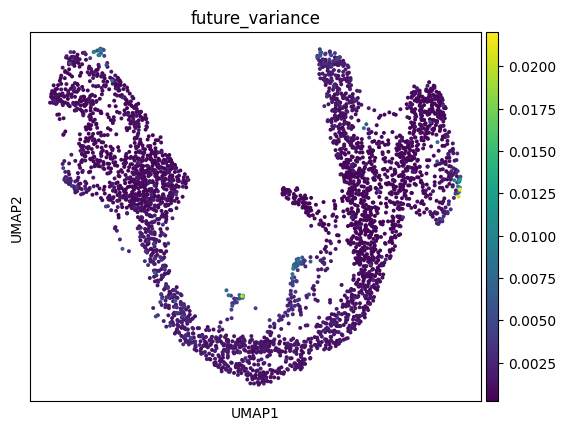

In [27]:
# Level of disagreement per cell 

future_variance = np.mean(np.var(pca_futures,axis=0),axis=1)

filtered.obs['future_variance'] = future_variance

sc.pl.umap(filtered,color="future_variance")

In [ ]:
# Relationship to depth 